## Create Input/Output Interface

### Subtask:
Create a simple interface to allow users to upload an image and display the detection output using the trained model and the inference function.

**Reasoning**:
Use `ipywidgets` to create a file upload button. Define a function to handle the uploaded image, save it, and call the `detect_rust` function with the uploaded image path and the trained model. Display the output.

In [ ]:
from ipywidgets import FileUpload, Output
from IPython.display import display
import os
import matplotlib.pyplot as plt

# Create a FileUpload widget
upload_button = FileUpload(
    accept='image/*',  # Accept only image files
    multiple=False     # Allow only one file upload at a time
)

# Create an Output widget to display the results
output_widget = Output()

def estimate_lifespan(confidence):
    """Simple rule-based lifespan estimation based on rust confidence."""
    if confidence < 0.3:
        return "2+ years (rust unlikely)"
    elif confidence < 0.6:
        return "2–3 months (early rust signs)"
    elif confidence < 0.8:
        return "Less than 1 month (moderate rust)"
    else:
        return "Not useable (heavy rust)"

def detect_rust(image_path, model):
    """Run YOLO model and return rust detection info."""
    results = model(image_path)           # Run inference
    detections = results[0].boxes         # YOLOv8/YOLOv5 format

    if len(detections) > 0:
        conf = float(detections.conf.max().cpu().numpy())  # highest confidence
        return {"rust": True, "confidence": conf, "results": results}
    else:
        return {"rust": False, "confidence": 0.0, "results": results}

def handle_upload(change):
    uploaded_files = upload_button.value
    if uploaded_files:
        file_name = list(uploaded_files.keys())[0]
        file_info = uploaded_files[file_name]
        file_content = file_info['content']

        temp_image_path = f"/content/{file_name}"
        with open(temp_image_path, 'wb') as f:
            f.write(file_content)

        output_widget.clear_output()

        with output_widget:
            print(f"Running detection on {file_name}...")
            try:
                result = detect_rust(temp_image_path, model)
                rust_detected = result["rust"]
                confidence = result["confidence"]
                results = result["results"]

                if rust_detected:
                    print(f"Rust detected ✅ (confidence: {confidence:.2f})")
                    lifespan = estimate_lifespan(confidence)
                    print(f"Estimated lifespan: {lifespan}")
                else:
                    print(f"No rust detected ❌ (confidence: {confidence:.2f})")
                    print("Estimated lifespan: 5+ years (no visible rust)")

                # Show annotated image
                annotated_img = results[0].plot()  # draws boxes & labels
                plt.figure(figsize=(8, 6))
                plt.axis("off")
                plt.imshow(annotated_img)
                plt.show()

            except NameError:
                print("Error: 'model' or 'detect_rust' not defined. Please ensure they are loaded.")
            except Exception as e:
                print(f"An error occurred during detection: {e}")

upload_button.observe(handle_upload, names='value')
display(upload_button, output_widget)


FileUpload(value={}, accept='image/*', description='Upload')

Output()

## Create Inference Function

### Subtask:
Write a function to take an image path as input, run inference using the trained model, and display the output with detections.

**Reasoning**:
Define a function that takes an image path, loads the trained YOLOv8 model, performs inference on the image, and displays the image with the detected rust.

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def detect_rust(image_path, model):
    """
    Performs rust detection on an image using a trained YOLOv8 model and displays the result.

    Args:
        image_path (str): The path to the input image.
        model: The trained YOLOv8 model.
    """
    # Perform inference
    results = model(image_path)

    # Load the image for display
    img = Image.open(image_path)

    # Create a plot
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    # Add bounding boxes and labels to the plot
    if results and results[0].boxes:
        for box in results[0].boxes:
            # Extract box coordinates (xyxy format)
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            conf = box.conf[0].item()
            cls = int(box.cls[0].item())

            # Create a Rectangle patch
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')

            # Add the patch to the Axes
            ax.add_patch(rect)

            # Add label
            label = f"{model.names[cls]}: {conf:.2f}"
            plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()

In [ ]:
# Access precision and recall (scalars)
precision = model.metrics.box.p.item()
recall = model.metrics.box.r.item()

# Calculate F1 score
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Access mAP@0.5 and mAP@0.5:0.95 (convert to scalar)
map50 = model.metrics.box.map50.item()
map = model.metrics.box.map.item()

# Print metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"mAP@0.5: {map50:.4f}")
print(f"mAP@0.5:0.95: {map:.4f}")


Precision: 0.6442
Recall: 0.5581
F1 Score: 0.5981
mAP@0.5: 0.5933
mAP@0.5:0.95: 0.3557


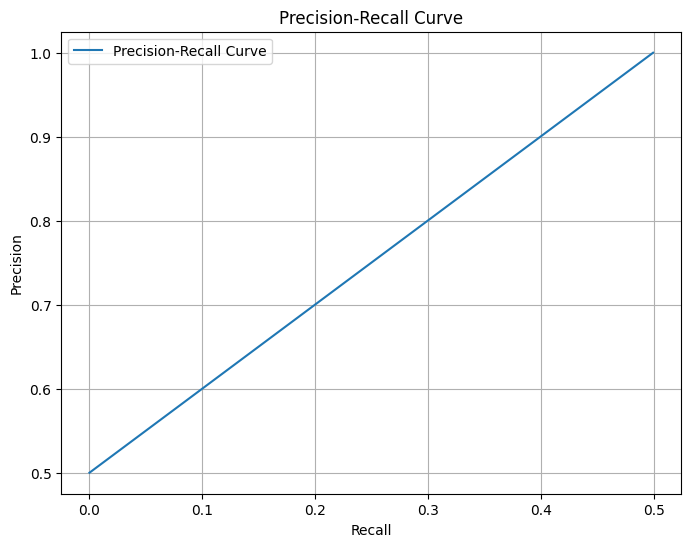

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Access the precision-recall curve data
# The curves_results attribute is a list of arrays for different curves
# The first element (index 0) typically corresponds to the Precision-Recall curve for the first class (rust)
pr_curve_data = model.metrics.curves_results[0][0]

# Assuming the 1D array is a concatenation of recall and precision values
# This is an educated guess based on the error and common data structures
num_points = len(pr_curve_data) // 2
recall_values = pr_curve_data[:num_points]
precision_values = pr_curve_data[num_points:]

# Ensure the number of recall and precision values match
if len(recall_values) != len(precision_values):
    print("Error: Could not correctly separate recall and precision values from the 1D array.")
else:
    plt.figure(figsize=(8, 6))
    plt.plot(recall_values, precision_values, label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
# Display the confusion matrix
model.metrics.confusion_matrix.plot()

In [ ]:
import pandas as pd
import numpy as np # Import numpy

# Access the confusion matrix data
confusion_matrix_data = model.metrics.confusion_matrix.matrix

# Convert the confusion matrix data to a pandas DataFrame for easier viewing and manipulation
# The rows represent the true labels, and the columns represent the predicted labels.
# Assuming the 2x2 matrix represents:
# Row 0: Actual Negative (No Rust)
# Row 1: Actual Positive (Rust)
# Column 0: Predicted Negative (No Rust)
# Column 1: Predicted Positive (Rust)

# Define appropriate labels for the 2x2 matrix
labels = ['No Rust', 'Rust']

confusion_matrix_df = pd.DataFrame(confusion_matrix_data, index=labels, columns=labels)

print("Confusion Matrix:")
display(confusion_matrix_df)

Confusion Matrix:


,No Rust,Rust
No Rust,2265.0,1481.0
Rust,1401.0,0.0


from matplotlib import pyplot as plt
confusion_matrix_df['No Rust'].plot(kind='hist', bins=20, title='No Rust')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
confusion_matrix_df['Rust'].plot(kind='hist', bins=20, title='Rust')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
confusion_matrix_df.plot(kind='scatter', x='No Rust', y='Rust', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
confusion_matrix_df['No Rust'].plot(kind='line', figsize=(8, 4), title='No Rust')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
confusion_matrix_df['Rust'].plot(kind='line', figsize=(8, 4), title='Rust')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_0['No Rust'].plot(kind='hist', bins=20, title='No Rust')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Rust'].plot(kind='hist', bins=20, title='Rust')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('index').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='No Rust', y='Rust', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4['No Rust'].plot(kind='line', figsize=(8, 4), title='No Rust')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_5['Rust'].plot(kind='line', figsize=(8, 4), title='Rust')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_6['index'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_6, x='No Rust', y='index', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_7['index'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_7, x='Rust', y='index', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

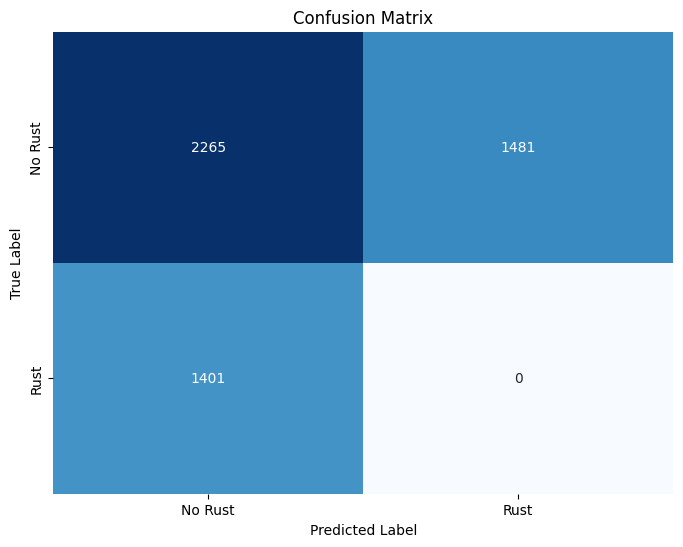

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Use the existing confusion_matrix_df
# confusion_matrix_df = pd.DataFrame(...) # Assuming confusion_matrix_df is already defined

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_df, annot=True, fmt='.0f', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

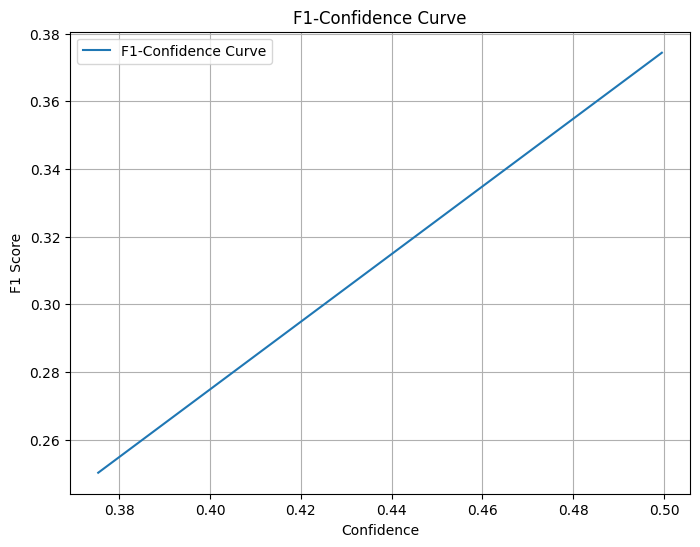

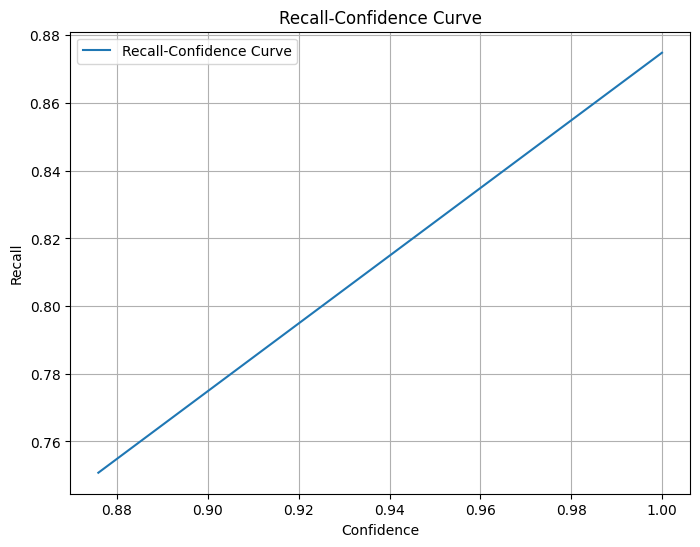

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Access the combined curve data (1D array)
all_curves_data = model.metrics.curves_results[0][0]

# Assuming each curve has 125 data points (metric, x-axis value pairs),
# and the data for the 4 curves is concatenated in the order:
# PR (recall, precision), F1-Confidence (F1, confidence),
# Precision-Confidence (precision, confidence), Recall-Confidence (recall, confidence)

num_points_per_curve = 125

# Data for F1-Confidence curve
f1_values = all_curves_data[2 * num_points_per_curve : 3 * num_points_per_curve]
confidence_values_f1 = all_curves_data[3 * num_points_per_curve : 4 * num_points_per_curve]

# Data for Recall-Confidence curve
recall_values_confidence = all_curves_data[6 * num_points_per_curve : 7 * num_points_per_curve]
confidence_values_recall = all_curves_data[7 * num_points_per_curve : 8 * num_points_per_curve]


# Plot F1-Confidence curve
plt.figure(figsize=(8, 6))
plt.plot(confidence_values_f1, f1_values, label='F1-Confidence Curve')
plt.xlabel('Confidence')
plt.ylabel('F1 Score')
plt.title('F1-Confidence Curve')
plt.grid(True)
plt.legend()
plt.show()

# Plot Recall-Confidence curve
plt.figure(figsize=(8, 6))
plt.plot(confidence_values_recall, recall_values_confidence, label='Recall-Confidence Curve')
plt.xlabel('Confidence')
plt.ylabel('Recall')
plt.title('Recall-Confidence Curve')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
from IPython.display import Image, display
import os

# Assuming the training results are saved in 'runs/detect/train'
# You might need to adjust the path if you used a different 'project' or 'name' during training
run_dir = '/content/runs/detect/train'

# List files in the run directory to find the plot images
if os.path.exists(run_dir):
    print(f"Listing files in {run_dir}:")
    print(os.listdir(run_dir))
else:
    print(f"Run directory not found: {run_dir}")

# Display the loss plot if it exists
loss_plot_path = os.path.join(run_dir, 'results.png') # Common filename for results plot

if os.path.exists(loss_plot_path):
    print(f"\nDisplaying loss plot from: {loss_plot_path}")
    display(Image(filename=loss_plot_path))
else:
    print(f"\nLoss plot not found at: {loss_plot_path}")
    print("Please check the 'runs/detect/train' directory for plot files.")

Run directory not found: /content/runs/detect/train

Loss plot not found at: /content/runs/detect/train/results.png
Please check the 'runs/detect/train' directory for plot files.


In [ ]:
import os

run_detect_dir = '/content/rust_dataset/detect'

if os.path.exists(run_detect_dir):
    print(f"Listing contents of {run_detect_dir}:")
    print(os.listdir(run_detect_dir))
else:
    print(f"Directory not found: {run_detect_dir}")

Listing contents of /content/rust_dataset/detect:
['train']


Listing files in /content/rust_dataset/detect/train:
['labels.jpg', 'val_batch0_labels.jpg', 'val_batch2_labels.jpg', 'train_batch0.jpg', 'BoxP_curve.png', 'train_batch7121.jpg', 'confusion_matrix.png', 'train_batch1.jpg', 'args.yaml', 'train_batch7122.jpg', 'BoxR_curve.png', 'val_batch1_labels.jpg', 'BoxPR_curve.png', 'val_batch2_pred.jpg', 'confusion_matrix_normalized.png', 'results.png', 'BoxF1_curve.png', 'train_batch7120.jpg', 'results.csv', 'val_batch0_pred.jpg', 'train_batch2.jpg', 'weights', 'val_batch1_pred.jpg']

Displaying loss plot from: /content/rust_dataset/detect/train/results.png


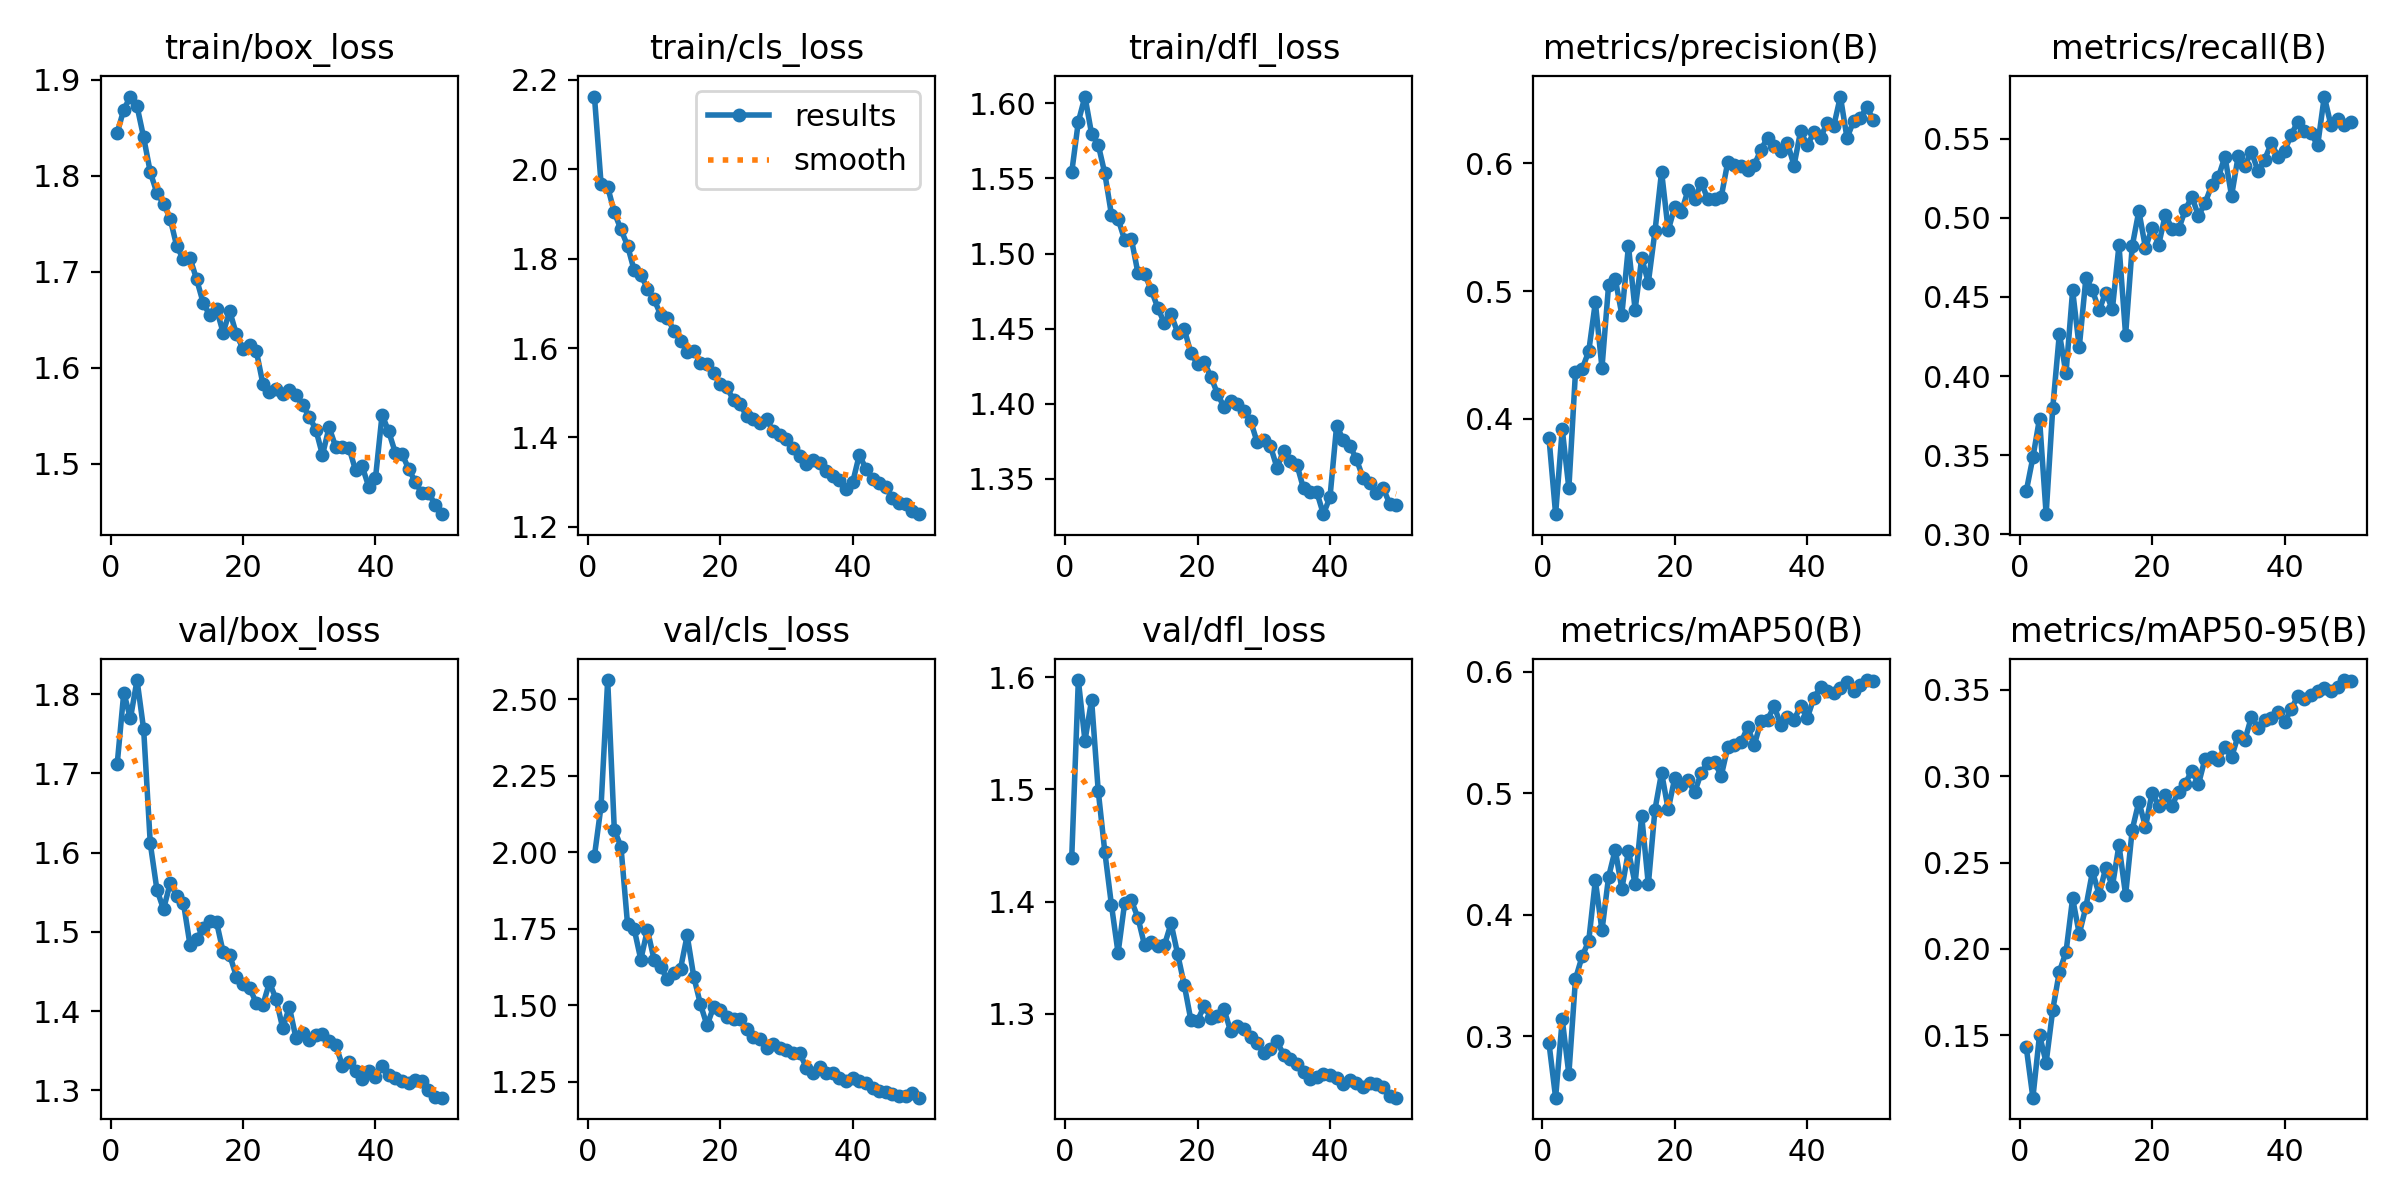

In [ ]:
import os
from IPython.display import Image, display

# Assuming the training results might be saved within the dataset directory
run_dir_alternative = '/content/rust_dataset/detect/train'

# List files in the alternative run directory
if os.path.exists(run_dir_alternative):
    print(f"Listing files in {run_dir_alternative}:")
    print(os.listdir(run_dir_alternative))

    # Display the loss plot if it exists in this alternative location
    loss_plot_path_alternative = os.path.join(run_dir_alternative, 'results.png') # Common filename for results plot

    if os.path.exists(loss_plot_path_alternative):
        print(f"\nDisplaying loss plot from: {loss_plot_path_alternative}")
        display(Image(filename=loss_plot_path_alternative))
    else:
        print(f"\nLoss plot not found at: {loss_plot_path_alternative}")
        print(f"Please check the '{run_dir_alternative}' directory for plot files.")
else:
    print(f"Alternative run directory not found: {run_dir_alternative}")

In [ ]:
display(model.metrics.curves_results)

[[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
            0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
            0.048048,    0.049049,     0.05005,    0.051051,    0.052052,    0.053053,    0.054054,    0.055055,    0.056056,    0.057057,    0.058058,    0.059059,     0.06006,    0.061061,    0.062062,    0.063063,    0.064064,    0.065065,    0.066066,    0.067067,    0.068068,    0.069069,     0.07007,    0.071071,
            0.072072,    0.073073,   

In [ ]:
# Display the confusion matrix
model.metrics.confusion_matrix.plot()

In [ ]:
display(model.metrics)

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a0f2745b500>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

# Task
Create a rust detection project using YOLOv8. The project should use the dataset "rust.v1i.yolov8.zip" located in the "ise" folder on Google Drive. The project should include an input phase to upload an image and display the detection output.

## Setup environment

### Subtask:
Install necessary libraries, including `ultralytics` for YOLOv8 and `google-colab` for accessing Google Drive.


**Reasoning**:
Install the necessary libraries `ultralytics` and `google-colab` using pip.



In [ ]:
%pip install ultralytics google-colab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 78.1 MB/s eta 0:00:00


## Access dataset

### Subtask:
Mount Google Drive to access the dataset and unzip the dataset file.


**Reasoning**:
Mount Google Drive and unzip the dataset.



In [ ]:
from google.colab import drive

drive.mount('/content/drive')

!unzip /content/drive/MyDrive/ise/rust.v1i.yolov8.zip -d /content/rust_dataset

Streaming output truncated to the last 5000 lines.
 extracting: /content/rust_dataset/train/images/CM26_png_jpg.rf.a47e2cc923b57365bc9b06ae1548fd1d.jpg  
 extracting: /content/rust_dataset/train/images/CM26_png_jpg.rf.a72a7ab172705bd81a08c85799728ec4.jpg  
 extracting: /content/rust_dataset/train/images/CM26_png_jpg.rf.a9909cea07a06fd9c008e41cfe534187.jpg  
 extracting: /content/rust_dataset/train/images/CM26_png_jpg.rf.afbfaea1ada8efc3c199d9ea9aa6b3f1.jpg  
 extracting: /content/rust_dataset/train/images/CM26_png_jpg.rf.b583e715d10edfcbb99ee2cb3c2197b4.jpg  
 extracting: /content/rust_dataset/train/images/CM26_png_jpg.rf.c08dc87258786fc23f03395d030e1146.jpg  
 extracting: /content/rust_dataset/train/images/CM26_png_jpg.rf.c3fe5aa84a2fb118f25f62514240457a.jpg  
 extracting: /content/rust_dataset/train/images/CM26_png_jpg.rf.dfed30539e117685634f4bb41e7cd2a2.jpg  
 extracting: /content/rust_dataset/train/images/CM26_png_jpg.rf.e32dfbfb7c7fc3e119aac7cfc541dd0e.jpg  
 extracting: /content/

## Train model

### Subtask:
Train a YOLOv8 model on the rust detection dataset.


**Reasoning**:
Import the YOLO class, instantiate a YOLO model, and train it using the specified dataset configuration file, number of epochs, and image size.



In [ ]:
from ultralytics import YOLO

# Instantiate a YOLO model
model = YOLO('yolov8n.pt')  # Using yolov8n.pt for a nano model

# Train the model
model.train(data='/content/rust_dataset/data.yaml', epochs=50, imgsz=640)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.203 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/rust_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, kera

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a0f2745b500>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

**Reasoning**:
The first step is to load the data from the CSV file into a pandas DataFrame and display the first few rows to understand its structure.



In [ ]:
import pandas as pd

df = pd.read_csv('/data/train.csv')
display(df.head())

FileNotFoundError: [Errno 2] No such file or directory: '/data/train.csv'

**Reasoning**:
The previous command failed because the file '/data/train.csv' was not found. I need to check the available files in the '/data/' directory to identify the correct file name.



In [ ]:
import os
print(os.listdir('/data/'))

FileNotFoundError: [Errno 2] No such file or directory: '/data/'

**Reasoning**:
The previous command also failed because the directory '/data/' was not found. It seems the data is not located in the expected path. I will try listing files in the current directory to see if the data is there.



In [ ]:
import os
print(os.listdir('.'))

['.config', 'yolov8n.pt', 'rust_dataset', 'runs', 'yolo11n.pt', 'drive', 'sample_data']


**Reasoning**:
The data file is not in the '/data/' directory or the current directory. The output of listing the current directory shows 'rust_dataset'. It is likely that the training data is within this directory. I need to explore the contents of 'rust_dataset' to find the training data file.



In [ ]:
import os
print(os.listdir('./rust_dataset'))

['data.yaml', 'README.dataset.txt', 'README.roboflow.txt', 'train', 'test', 'valid']


**Reasoning**:
The previous command showed that the 'rust_dataset' directory contains 'train', 'test', and 'valid' subdirectories. The training data is likely within the 'train' directory. I need to list the contents of the 'train' directory to find the actual training data file, which is likely a CSV or similar file.



In [ ]:
import os
print(os.listdir('./rust_dataset/train'))

['images', 'labels.cache', 'labels']


**Reasoning**:
The previous command shows that the 'train' directory contains 'images', 'labels.cache', and 'labels'. The training data labels are likely in the 'labels' directory. I need to list the contents of the 'labels' directory to find the actual training data file. Since the main task is about data analysis and potentially training, the labels directory is the most likely place for structured data like a CSV.



In [ ]:
import os
print(os.listdir('./rust_dataset/train/labels'))

['CL15_png_jpg.rf.9035633fd769d2f7c2c34750686f555e.txt', 'CM3_png_jpg.rf.b8280b83b251ff4b83d28c4f19327f45.txt', 'S27_png_jpg.rf.be60b6ee0395da4dbcb8418954800a3e.txt', 'CS8_jpg.rf.bcaee6b134be5ef6fda4d8390f0f5ccd.txt', 'CL9_jpg.rf.a56c427aabcaf6ccdd8371a7b0e37991.txt', 'CS7_png_jpg.rf.f426fc427ec93ec80664264049c64646.txt', '000347_png_jpg.rf.fc72151b05a4a41175c1f029ae11e6ef.txt', 'M1_jpg.rf.ba32e3b27454a4b053dc8ca481d0ac35.txt', 'S2_jpg.rf.32da52feb806db91d1c1956f746dba88.txt', '000226_png_jpg.rf.8f57f73c611e69491bdd8a661cc4af22.txt', 'CM36_jpg.rf.fbaac9a164df2df451a01ba1ffb4b228.txt', 'CS19_png_jpg.rf.2001c107a28e9cdfc90cb663a4180f18.txt', '000387_jpg.rf.d27199c5d12bd2c9cd0f9c914e8210ef.txt', 'CM26_png_jpg.rf.9f54f92cc75bbe2b179fe01af77f9c32.txt', 'CL6_jpg.rf.8143a404249ca67ff18e7d6fe50c310a.txt', 'craiyon_082045_rust_on_a_metal_surface_png_jpg.rf.9a8d423127668ef6d72e97a545206a90.txt', 'L12_jpg.rf.81f73974d4e6e0e70ad7bb07ce24014f.txt', '1_jpg.rf.21646b67dd453ce8fc4a315ca7afc447.txt', '

**Reasoning**:
The previous command listed many '.txt' files, each likely containing labels for a single image in the format used for object detection (YOLO format). These files are not in a tabular format suitable for direct loading into a pandas DataFrame for analysis. I need to read these text files, parse the data within them, and then structure that data into a pandas DataFrame. Each line in these text files represents an object detected in an image, with values typically representing class, x_center, y_center, width, and height. I will read one of these files to understand the format and then write code to process all files.



In [ ]:
import glob

# Get a list of all text files in the directory
label_files = glob.glob('./rust_dataset/train/labels/*.txt')

# Read and display the content of the first file to understand the format
if label_files:
    with open(label_files[0], 'r') as f:
        first_file_content = f.read()
    print(f"Content of the first label file ({label_files[0]}):\n")
    print(first_file_content)
else:
    print("No label files found in the directory.")

Content of the first label file (./rust_dataset/train/labels/CL15_png_jpg.rf.9035633fd769d2f7c2c34750686f555e.txt):

0 0.6131996843749999 0 0.6162707890625 0.010858950000000001 0.6346117421875 0.0137902203125 0.6526334421875 0.0090254390625 0.658195184375 0.00035803749999999997 0.6578007046875001 0 0.6131996843749999 0
0 0.8237562609375001 0.9499552640625 0.7910618 0.9523750312500001 0.783695690625 0.9559759140624999 0.7818535890625 0.97229073125 0.8387637531250001 0.970303384375 0.842037759375 0.9624333171874999 0.8237562609375001 0.9499552640625
0 0.6082183765625 0.596327875 0.5616680265625 0.5831543796875 0.519773359375 0.5888819015625 0.5284759421875 0.6065184421875001 0.5666132359375 0.6145248390625 0.600443828125 0.6065528796875 0.6082183765625 0.596327875
0 0.5545345515625 0.1366914421875 0.5458022406249999 0.1238282921875 0.4628892390625 0.11248830781250001 0.45141677343750003 0.12690045156250002 0.5452451625 0.154319371875 0.5522325625 0.1525692203125 0.5545345515625 0.1366914